# Network Trainer

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

### Data Transformation
We need to prepare the data before feeding it to the network. This transformation also has to be applied to the images we use as input for prediction later. Therefore we have to include it in the ROS processor node.

- **transforms.ToTensor()** - converts the image into numbers, that are understandable by the system. It separates the image into three color channels (separate images): red, green & blue. Then it converts the pixels of each image to the brightness of their color between 0 and 255. These values are then scaled down to a range between 0 and 1. The image is now a Torch Tensor.
- **transforms.Normalize()** - normalizes the tensor with a mean and standard deviation which goes as the two parameters respectively.

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

### Load the MNIST Dataset

In [7]:
# Download the dataset and apply the transformation.
trainset = datasets.MNIST('Datasets/Train', download=True, train=True, transform=transform)
valset = datasets.MNIST('Datasets/Validate', download=True, train=False, transform=transform)

100.1%

Extracting Datasets/Train/MNIST/raw/train-images-idx3-ubyte.gz to Datasets/Train/MNIST/raw


113.5%

Extracting Datasets/Train/MNIST/raw/train-labels-idx1-ubyte.gz to Datasets/Train/MNIST/raw


100.4%

Extracting Datasets/Train/MNIST/raw/t10k-images-idx3-ubyte.gz to Datasets/Train/MNIST/raw


180.4%

Extracting Datasets/Train/MNIST/raw/t10k-labels-idx1-ubyte.gz to Datasets/Train/MNIST/raw
Processing...
Done!


100.1%

Extracting Datasets/Validate/MNIST/raw/train-images-idx3-ubyte.gz to Datasets/Validate/MNIST/raw


113.5%

Extracting Datasets/Validate/MNIST/raw/train-labels-idx1-ubyte.gz to Datasets/Validate/MNIST/raw


100.4%

Extracting Datasets/Validate/MNIST/raw/t10k-images-idx3-ubyte.gz to Datasets/Validate/MNIST/raw


180.4%

Extracting Datasets/Validate/MNIST/raw/t10k-labels-idx1-ubyte.gz to Datasets/Validate/MNIST/raw
Processing...
Done!


In [10]:
# Prepare data loaders to feed the network batches of random images.
loader_train = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
loader_test = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

### Data Exploration

In [12]:
# We want to get information of the tensor shapes.
data_iterator = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


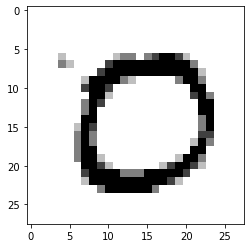

In [15]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

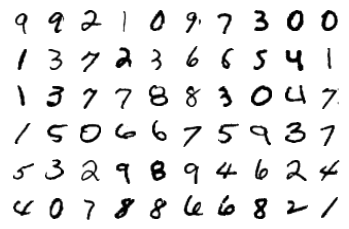

In [14]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Build the Neural Network

In [17]:
# The input size is one unwrapped image (1 x 28 x 28).
# We get 784 neurons as the input layer.
input_size = 784
# The first hidden layer has 128 and the secon 64.
hidden_sizes = [128, 64]
# The output layer has ten neurons for the numbers 0-9.
output_size = 10
# Build the model by chaining up the layers sequentially.
# We use ReLU as the activation function.
# The softmax function at the end does the classification.
# This will select the one out of ten neurons which scores best.
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


### Define the Loss Function
Next, we define the negative log-likelihood loss. It is useful to train a classification problem with C classes. Together the LogSoftmax() and NLLLoss() acts as the cross-entropy loss.

In [18]:
# negative log-likelihood loss
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
# TODO Examine this a bit further!
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [19]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 1.9183e-03,  1.9183e-03,  1.9183e-03,  ...,  1.9183e-03,
          1.9183e-03,  1.9183e-03],
        [ 3.1301e-03,  3.1301e-03,  3.1301e-03,  ...,  3.1301e-03,
          3.1301e-03,  3.1301e-03],
        [-3.2168e-04, -3.2168e-04, -3.2168e-04,  ..., -3.2168e-04,
         -3.2168e-04, -3.2168e-04],
        ...,
        [-1.8880e-03, -1.8880e-03, -1.8880e-03,  ..., -1.8880e-03,
         -1.8880e-03, -1.8880e-03],
        [ 2.7977e-06,  2.7977e-06,  2.7977e-06,  ...,  2.7977e-06,
          2.7977e-06,  2.7977e-06],
        [-2.4775e-03, -2.4775e-03, -2.4775e-03,  ..., -2.4775e-03,
         -2.4775e-03, -2.4775e-03]])


### Train the Model

In [20]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        # This is where the model learns by backpropagating.
        loss.backward()
        
        # And optimizes its weights here.
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6423388388174683
Epoch 1 - Training loss: 0.2849011261429169
Epoch 2 - Training loss: 0.2200673726687172
Epoch 3 - Training loss: 0.17934345183516742
Epoch 4 - Training loss: 0.14983445223468517
Epoch 5 - Training loss: 0.1274026926261371
Epoch 6 - Training loss: 0.11269898377835497
Epoch 7 - Training loss: 0.09918885845849827
Epoch 8 - Training loss: 0.08958862455430697
Epoch 9 - Training loss: 0.0804219303745975
Epoch 10 - Training loss: 0.07310648702694647
Epoch 11 - Training loss: 0.06778381254448533
Epoch 12 - Training loss: 0.061466345851962916
Epoch 13 - Training loss: 0.05627817785995864
Epoch 14 - Training loss: 0.0527012852799477

Training Time (in minutes) = 2.78670871257782


### Validation

In [22]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 8


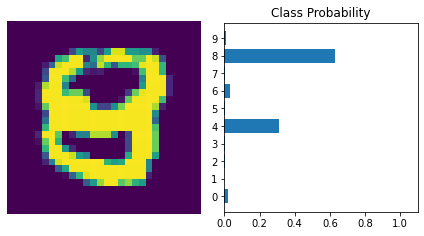

In [23]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

Now we iterate through the validation set using a for loop and calculate the total number of correct predictions. This is how we can calculate the accuracy.

In [27]:
correct_count, all_count = 0, 0
for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)

    
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9721


### Save Model

In [26]:
torch.save(model, './Models/mnist_model_01.pt') 

### Sources:
- https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627